## Imports
---

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import umap
from model import CNet2D
from dataloader import 

## Load data

In [ ]:
folder_path = "data/nearlab/normal/sbj1/"


# Training
---

In [ ]:
def train_model(model, X_train, y_train, epochs=1, batch_size=128, learning_rate=0.001, optimizer_type='ADAM', version='GLVQ'):
    # Reshape data
    def reshape_data(X):
        return X.reshape(X.shape[0], 1, -1, X.shape[-1])

    X_train = reshape_data(X_train)
    
    # Create dataset and loader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Init optimizer
    if optimizer_type == "ADAM":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type. Use 'adam' or 'sgd'.")

    # Training loop
    loss_epoch = []
    for epoch in range(epochs):
        model.train()
        epoch_losses = []

        for batch_X, batch_y in train_loader:
            # Reset Gradient
            optimizer.zero_grad()

            # GLVQ and GLMVQ Version
            if version == "GLVQ" or version == "GMLVQ":
                features = model(batch_X)
                # Forward pass through GLVQ layer
                loss = model.fc3(features, batch_y)
            else:  # Softmax version
                outputs = model(batch_X)
                loss = nn.CrossEntropyLoss()(outputs, batch_y)

            epoch_losses.append(loss.item())
            # Backward step
            loss.backward()
            # Update weights
            optimizer.step()

        avg_loss = np.mean(epoch_losses)
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss:.4f}')

    return model

model = CNet2D()
train_model(model, X_train, y_train, epochs=1, batch_size=64, learning_rate=0.001, optimizer_type='ADAM', version=version)

torch.Size([5662, 10, 512])
torch.Size([5662, 1, 10, 512])
Epoch 1/1, Average Loss: 0.3518


CNet2D(
  (conv1): Conv2d(1, 32, kernel_size=(3, 13), stride=(1, 1), padding=(1, 6))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rrelu1): RReLU(lower=0.125, upper=0.3333333333333333)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 48, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4))
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rrelu2): RReLU(lower=0.125, upper=0.3333333333333333)
  (drop2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(48, 64, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rrelu3): RReLU(lower=0.125, upper=0.3333333333333333)
  (drop3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=40960, out_features=300, bias=True)
  (fc_bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_rrelu1): RReLU(lower=0.125, upper=0.3

# Plotting
---

d:\Miniconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


5120
[]


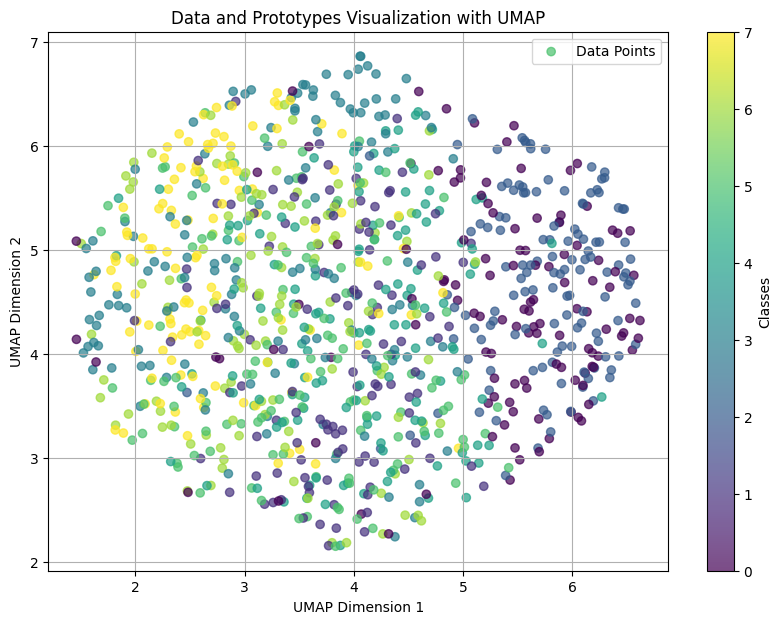

In [9]:
def plot_data_with_prototypes(model, X, y, num_classes):
    """
    Plots the data points and prototypes in a 2D space using UMAP for dimensionality reduction.

    Args:
        model (GLVQ or GMLVQ): Trained GLVQ or GMLVQ model.
        X (torch.Tensor): Input data of shape (n_samples, input_dim).
        y (torch.Tensor): Class labels for the input data.
        num_classes (int): Number of classes.
    """
    # Get the data back to numpy array
    X_np = X.detach().cpu().numpy()
    if X_np.ndim > 2:  # Flatten the data if it has more than 2 dimensions
        X_np = X_np.reshape(X_np.shape[0], -1)
    y_np = y.detach().cpu().numpy()
    prototypes_np = model.prototypes.detach().cpu().numpy()
    prototypes_labels_np = model.prototype_labels.detach().cpu().numpy()

    combined_labels = np.hstack([y_np, prototypes_labels_np])

    # Reduce dimension with UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.05, metric='euclidean', random_state=42)
    reduced_data = reducer.fit_transform(X_np)

    print(len(X_np[0]))

    # Separate reduced data
    reduced_X = reduced_data[:len(X_np)]
    reduced_prototypes = reduced_data[len(X_np):]

    print(reduced_prototypes)

    # Plot the data points
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=y_np, cmap='viridis', label='Data Points', alpha=0.7)
    plt.colorbar(scatter, label="Classes")

    # Final plot settings
    plt.title('Data and Prototypes Visualization with UMAP')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_with_prototypes(model.fc3, X_train[:1000], y_train[:1000], num_classes=8)


# Evaluation
---

In [14]:
model.eval()
with torch.no_grad():
    if version == "GLVQ":
        # Get features
        features = model(X_test)
        # Use GLVQ predict method
        predicted = model.fc3.predict(features)
    elif version == "GLMVQ":  
        # Use GLMVQ predict method
        features = model(X_test)
        predicted = model.fc3.predict(features)
    else:  # Softmax version
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
    
    # Calculate accuracy
    accuracy = (predicted == y_test).float().mean()
    print(f'Test Accuracy: {accuracy.item():.6f}')

RuntimeError: Given groups=1, weight of size [32, 1, 3, 13], expected input[1, 2498, 10, 512] to have 1 channels, but got 2498 channels instead